<a href="https://colab.research.google.com/github/vu-blaze-12/cnu-continual-rg/blob/main/example_cnu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Introduction

This notebook shows how to define and use Continua Neural Units (**CNUs**).

Let's start by cloning the repository containing the library.

In [1]:
!git clone https://github.com/sailab-code/continual_neural_unit

Cloning into 'continual_neural_unit'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 29), reused 49 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.17 MiB | 3.88 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
%cd continual_neural_unit
!pip install -r requirements.txt

/content/continual_neural_unit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_ncc

Import libraries and utils

In [ ]:
import torch
import torch.nn as nn
from d2d.utils_2d_datasets import load_toy_dataset, fill_row_in_continual_confusion_matrix, \
    print_continual_confusion_matrix, update_metrics, print_metrics, check_validity_of_distributions, \
    create_metrics_dictionary, convert_toy_dataset_to_pytorch_tensors, create_continual_confusion_matrix, \
    plot_2d_data_and_predictions, add_keys_from_continual_memory_neurons

Now, let's import a 2d dataset (MODES dataset, see the main paper for further details).

In [ ]:
# --------------------
# CUSTOMIZABLE OPTIONS
# --------------------
device = torch.device('cpu')
# file = "d2d/generated_datasets/bi-modals_IID.npz"
file = "d2d/generated_datasets/bi-modals_CI.npz"
# file = "d2d/generated_datasets/bi-modals_CDI.npz"
# file = "d2d/generated_datasets/bi-modals_CDID.npz"
# file = "d2d/generated_datasets/bi-moons_IID.npz"
# file = "d2d/generated_datasets/bi-moons_CI.npz"
# file = "d2d/generated_datasets/bi-moons_CDI.npz"
# file = "d2d/generated_datasets/bi-moons_CDID.npz"
# --------------------

# loading data
loaded_data, d, c = load_toy_dataset(file)  # loading data (returns: data dictionary, input size, num classes)

# converting data collections (train, val, test) to torch tensors, right format, right device
X_train, y_train, distributions_train, X_val, y_val, distributions_val, X_test, y_test, distributions_test = \
    convert_toy_dataset_to_pytorch_tensors(loaded_data, device)

# checking validity of the distribution indices (better be sure!)
check_validity_of_distributions(distributions_train, distributions_val, distributions_test)

Now, let's create a vanilla MLP


In [ ]:
# creating the neural network
net = nn.Sequential(
    nn.Linear(in_features=d, out_features=10, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=c, bias=True)
).to(device)

Let's test this model on the online domain-incremental 2d MODES dataset, and plot the decision surfaces.

In [ ]:
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.09)

# continual confusion matrices (empty, -1 means "unfilled yet", important!)
CCM_train = create_continual_confusion_matrix(distributions_train)
CCM_val = create_continual_confusion_matrix(distributions_val)
CCM_test = create_continual_confusion_matrix(distributions_test)

# metrics containers (empty, -1 means "unfilled yet", important!)
metrics_train = create_metrics_dictionary(distributions_train)
metrics_val = create_metrics_dictionary(distributions_val)
metrics_test = create_metrics_dictionary(distributions_test)

# streaming loop
net.train()
for t, (x, y, distribution) in enumerate(zip(X_train, y_train, distributions_train)):

    # adding batch size and clearing up the tensor box
    x.unsqueeze_(0)
    y.unsqueeze_(0)
    distribution = distribution.item()

    # learning step
    o = net(x)
    loss = nn.functional.cross_entropy(o, y, reduction='mean')  # no real reductions are actually performed...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing
    if t % 100 == 0:
      print('t=' + str(t) + ', loss=' + str(loss.item()))

    # metrics (computed when training ends or when the distribution is going to change on the next step)
    if t == X_train.shape[0] - 1 or distributions_train[t + 1] != distribution:

        # adding a new row to the continual confusion matrices (exploiting the current network)
        fill_row_in_continual_confusion_matrix(CCM_train, distribution, net, X_train, y_train, distributions_train)
        fill_row_in_continual_confusion_matrix(CCM_val, distribution, net, X_val, y_val, distributions_val)
        fill_row_in_continual_confusion_matrix(CCM_test, distribution, net, X_test, y_test, distributions_test)

        # updating metrics
        update_metrics(metrics_train, CCM_train, distribution)
        update_metrics(metrics_val, CCM_val, distribution)
        update_metrics(metrics_test, CCM_test, distribution)

        # printing continual confusion matrix
        print_continual_confusion_matrix('train', CCM_train)
        print_continual_confusion_matrix('val', CCM_val)
        print_continual_confusion_matrix('test', CCM_test)

        # printing metrics
        print_metrics('train', metrics_train, distribution)
        print_metrics('val', metrics_val, distribution)
        print_metrics('test', metrics_test, distribution)

# class dictionary
class_dict = {'Class ' + str(j): j for j in range(0, c)}


t=0, loss=1.3165416717529297
t=100, loss=5.125986263010418e-06
CCM (train):
    M/D |   0  |   1  |   2  |   3 
    ----+------+------+------+------
     0  | 1.00 | 0.00 | 0.00 | 0.00
     1  | N.A. | N.A. | N.A. | N.A.
     2  | N.A. | N.A. | N.A. | N.A.
     3  | N.A. | N.A. | N.A. | N.A.
CCM (val):
    M/D |   0  |   1 
    ----+------+------
     0  | 1.00 | 0.00
     1  | N.A. | N.A.
CCM (test):
    M/D |   0  |   1  |   2  |   3 
    ----+------+------+------+------
     0  | 1.00 | 0.00 | 0.00 | 0.00
     1  | N.A. | N.A. | N.A. | N.A.
     2  | N.A. | N.A. | N.A. | N.A.
     3  | N.A. | N.A. | N.A. | N.A.
Metrics (train)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
Metrics (val)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
Metrics (test)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
t=200, lo

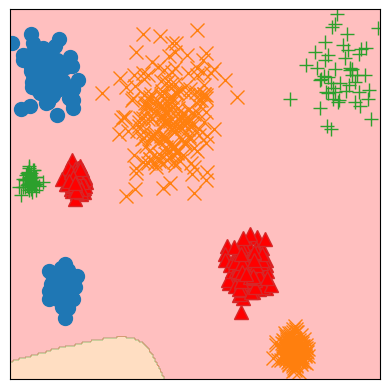

In [ ]:

# plotting predictions at the end of training
plot_2d_data_and_predictions('train', X_train, y_train, class_dict, net).show()

The model is not able to discern the different data distributions: it catastrophically forgets previous knwoledge.


Let's now test a Memory Head on the same task, defining it as follows:

In [ ]:
from cnu.layers import Linear as CNULinear
from d2d.utils_2d_datasets import add_keys_from_cnu
net = nn.Sequential(
    # nn.Linear(in_features=d, out_features=10, bias=True),
    # nn.Tanh(),
    # nn.Linear(in_features=10, out_features=c, bias=True)
    CNULinear(in_features=d, out_features=c, shared_keys=True, bias=True,
             key_mem_units=10,
             psi_fn="identity",
             # choices=["identity", "identity_psi", "resize2d_sign", "resize1d", "resize2d", "sign",  "2d_resize_psi"])
             upd_m="WTA",  # choices=["vanilla", "WTA"]
             upd_k="ad_hoc_WTA",  # choices=["ad_hoc_WTA", "grad_WTA", "grad_not_WTA"]
             beta_k=0.01,
             gamma_alpha=25.0, tau_alpha=0.95,
             tau_mu=50,
             tau_eta=50, scramble=True,
             delta=2,)
    ).to(device)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Define metrics

In [ ]:
# continual confusion matrices (empty, -1 means "unfilled yet", important!)
CCM_train = create_continual_confusion_matrix(distributions_train)
CCM_val = create_continual_confusion_matrix(distributions_val)
CCM_test = create_continual_confusion_matrix(distributions_test)

# metrics containers (empty, -1 means "unfilled yet", important!)
metrics_train = create_metrics_dictionary(distributions_train)
metrics_val = create_metrics_dictionary(distributions_val)
metrics_test = create_metrics_dictionary(distributions_test)

In [ ]:
# streaming loop
net.train()
for t, (x, y, distribution) in enumerate(zip(X_train, y_train, distributions_train)):

    # adding batch size and clearing up the tensor box
    x.unsqueeze_(0)
    y.unsqueeze_(0)
    distribution = distribution.item()

    # learning step
    o = net(x)
    loss = nn.functional.cross_entropy(o, y, reduction='mean')  # no real reductions are actually performed...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing
    if t % 100 == 0:
      print('t=' + str(t) + ', loss=' + str(loss.item()))

    # metrics (computed when training ends or when the distribution is going to change on the next step)
    if t == X_train.shape[0] - 1 or distributions_train[t + 1] != distribution:
        # adding a new row to the continual confusion matrices (exploiting the current network)
        fill_row_in_continual_confusion_matrix(CCM_train, distribution, net, X_train, y_train, distributions_train)
        fill_row_in_continual_confusion_matrix(CCM_val, distribution, net, X_val, y_val, distributions_val)
        fill_row_in_continual_confusion_matrix(CCM_test, distribution, net, X_test, y_test, distributions_test)

        # updating metrics
        update_metrics(metrics_train, CCM_train, distribution)
        update_metrics(metrics_val, CCM_val, distribution)
        update_metrics(metrics_test, CCM_test, distribution)

        # printing continual confusion matrix
        print_continual_confusion_matrix('train', CCM_train)
        print_continual_confusion_matrix('val', CCM_val)
        print_continual_confusion_matrix('test', CCM_test)

        # printing metrics
        print_metrics('train', metrics_train, distribution)
        print_metrics('val', metrics_val, distribution)
        print_metrics('test', metrics_test, distribution)



t=0, loss=1.4873265027999878
t=100, loss=0.3848642408847809
CCM (train):
    M/D |   0  |   1  |   2  |   3 
    ----+------+------+------+------
     0  | 1.00 | 0.16 | 0.35 | 0.01
     1  | N.A. | N.A. | N.A. | N.A.
     2  | N.A. | N.A. | N.A. | N.A.
     3  | N.A. | N.A. | N.A. | N.A.
CCM (val):
    M/D |   0  |   1 
    ----+------+------
     0  | 1.00 | 0.17
     1  | N.A. | N.A.
CCM (test):
    M/D |   0  |   1  |   2  |   3 
    ----+------+------+------+------
     0  | 1.00 | 0.14 | 0.28 | 0.01
     1  | N.A. | N.A. | N.A. | N.A.
     2  | N.A. | N.A. | N.A. | N.A.
     3  | N.A. | N.A. | N.A. | N.A.
Metrics (train)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
Metrics (val)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
Metrics (test)	at distribution ID 0: avg_accuracy=1.00, avg_forgetting=0.00, backward_transfer=0.00, forward_transfer=0.00
t=200, loss=

Now, let's plot the developed class separation surfaces, as long as the learned keys (blue stars).

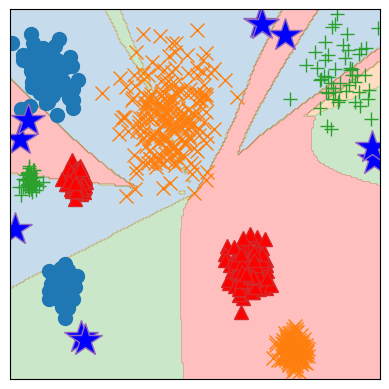

In [ ]:
# class dictionary
class_dict = {'Class ' + str(j): j for j in range(0, c)}

# getting keys, if any, adding them to the data, with an ad-hoc label
X_train, y_train, class_dict = add_keys_from_cnu(net, X_train, y_train, class_dict)

# plotting predictions at the end of training
plot_2d_data_and_predictions('train', X_train, y_train, class_dict, net).show()